## Team Project report
### Credit Card Fraud transaction predictor

Our team worked on the `SP500 dataset` the previous project, and our linear models were excellent predictors for the next day stock close price. This time we chose to explore a more realistic problem of detecting fraud credit card transactions. While building a model to solve this problem I realize how vital it is to identify, develop and train a model. While banks have the onus to keep customers happy, the technology they use could work againt them. While attempting to build a solid ML solution we understand the most important goal is to keep false-positive and false-negative predictions low.

### Loading dataset and necessary libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.calibration import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

CONST_TEST_SIZE = 0.25
CONST_FRAUD = 1
CONST_VALID = 0

## COMMON METHODS
#### PLOT CONFUSION MATRIX
def plot_confusion_matrix(cm, title, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt='.2f' if normalize else 'd'
    threshold = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j]>threshold else "black")
        
    plt.ylabel('TRUE label')
    plt.xlabel('PREDICTED label')
    plt.tight_layout()

#### ENCODE STRING VALUES
def stringTransform(columnNames):
    label_encoder = LabelEncoder()
    for columnName in columnNames:
        data_raw[columnName] = label_encoder.fit_transform(data_raw[columnName])

## LOADING DATASET
data_raw = pd.read_csv('../data/raw/credit-card-transactions.zip')

### Exploring data

In [2]:
## EXPLORING DATA
data_raw.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [3]:
## DATA COLUMN DETAILS
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

- Data standardization is necessary prior to processing them via the model
- While facing issues using OneHotEncoder to categorize string/object values, I chose to use StandardScaler.fit_transform to group values and assigning them numbers
- Post data pre-preocessing I will use the data correlation heatmap to understand relationship between the features 

In [4]:
## PRE_PROCESSING
## Fit and transform the string and number columns, and remove redundant data
data_raw['fullname'] = data_raw['first'] + ' ' + data_raw['last']
stringTransform(["merchant", "merch_zipcode", "job", "street", "city", "state", "gender", "category", "fullname"])
data_raw['amt'] = StandardScaler().fit_transform(data_raw['amt'].values.reshape(-1,1))
data_raw.drop(columns=['trans_date_trans_time', 'dob', 'trans_num', 'first', 'last', 'fullname'], inplace=True)
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 19 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1296675 non-null  int64  
 1   cc_num         1296675 non-null  int64  
 2   merchant       1296675 non-null  int32  
 3   category       1296675 non-null  int32  
 4   amt            1296675 non-null  float64
 5   gender         1296675 non-null  int32  
 6   street         1296675 non-null  int32  
 7   city           1296675 non-null  int32  
 8   state          1296675 non-null  int32  
 9   zip            1296675 non-null  int64  
 10  lat            1296675 non-null  float64
 11  long           1296675 non-null  float64
 12  city_pop       1296675 non-null  int64  
 13  job            1296675 non-null  int32  
 14  unix_time      1296675 non-null  int64  
 15  merch_lat      1296675 non-null  float64
 16  merch_long     1296675 non-null  float64
 17  is_fraud

In [5]:
## NULL CHECK
data_raw.isnull().sum()

Unnamed: 0       0
cc_num           0
merchant         0
category         0
amt              0
gender           0
street           0
city             0
state            0
zip              0
lat              0
long             0
city_pop         0
job              0
unix_time        0
merch_lat        0
merch_long       0
is_fraud         0
merch_zipcode    0
dtype: int64

In [6]:
## REMOVING DUPES
data_raw.drop_duplicates(inplace=True)

In [7]:
## VERIFY DATASET SHAPE
print(data_raw.shape)

(1296675, 19)


In [8]:
## DATA DESCRIBE
data_raw.describe()

,Unnamed: 0,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,3.428585e+02,6.227787e+00,-9.447052e-18,4.525513e-01,4.880344e+02,4.452633e+02,2.667728e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,2.511734e+02,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,1.588147e+04
std,3.743180e+05,1.308806e+18,2.009519e+02,3.913443e+00,1.000000e+00,4.977437e-01,2.800608e+02,2.586001e+02,1.433098e+01,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.401094e+02,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,9.033664e+03
min,0.000000e+00,6.041621e+10,0.000000e+00,0.000000e+00,-4.325897e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,0.000000e+00,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,0.000000e+00
25%,3.241685e+05,1.800429e+14,1.650000e+02,3.000000e+00,-3.786337e-01,0.000000e+00,2.520000e+02,2.240000e+02,1.500000e+01,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.310000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,7.892000e+03
50%,6.483370e+05,3.521417e+15,3.460000e+02,6.000000e+00,-1.424127e-01,0.000000e+00,4.850000e+02,4.390000e+02,2.800000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,2.510000e+02,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,1.567800e+04
75%,9.725055e+05,4.642255e+15,5.140000e+02,1.000000e+01,7.977349e-02,1.000000e+00,7.200000e+02,6.770000e+02,3.800000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,3.740000e+02,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,2.398100e+04
max,1.296674e+06,4.992346e+18,6.920000e+02,1.300000e+01,1.801352e+02,1.000000e+00,9.820000e+02,8.930000e+02,5.000000e+01,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,4.930000e+02,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,2.833600e+04


<Axes: >

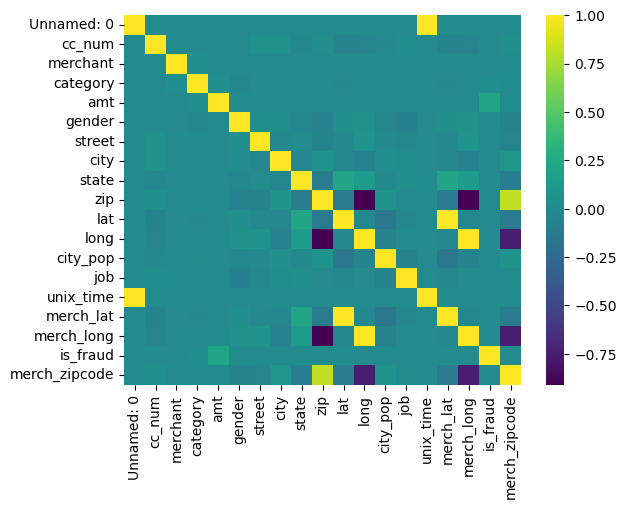

In [9]:
## DATA CORRELATION HEATMAP
corr = data_raw.corr()
sns.heatmap(corr, 
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
cmap='viridis')

- From the plot above there are clearly a few values the have greater than 75% likehood to predict the outcome
- Very few features seem to have zero or negative correlation to a few others, which still doesnt justify deleting them

### MODEL
- Using the two major classifier models we will try to find the best performer
- We will qualify the best performing model based on `recall`, `score` and one with least number of false-negative/false-positves int he heatmap

In [10]:
## MODEL INPUT
X = data_raw.drop(columns=['is_fraud'])
y = data_raw['is_fraud']

In [11]:
## SAMPLE SPLITING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CONST_TEST_SIZE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(972506, 18) (324169, 18) (972506,) (324169,)


In [12]:
## RANDOM FOREST CLASSIFIER SCORE
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train.values.ravel())
y_pred = random_forest.predict(X_test)
print("Random Forest Classifier score (Test dataset): ", random_forest.score(X_test, y_test))

Random Forest Classifier score (Test dataset):  0.9973871653365991


Confusion matrix, without normalization
[[322029    166]
 [   681   1293]]


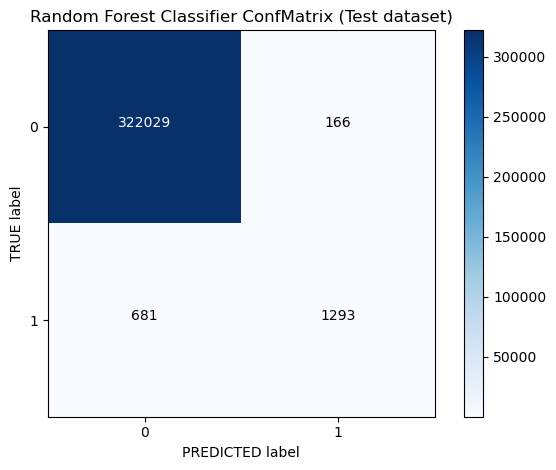

In [13]:
## RANDOM FOREST CLASSIFIER CONFUSION MATRIX
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, "Random Forest Classifier ConfMatrix (Test dataset)", classes=[CONST_VALID, CONST_FRAUD])

In [14]:
## RANDOM FOREST PERFORMANCE: RECALL
recall = recall_score(y_test, y_pred)
print(f"Recall (Random Forest): {recall}")

Recall (Random Forest): 0.6550151975683891


In [15]:
## DECISION TREE CLASSIFIER SCORE
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train.values.ravel())
y_pred = decision_tree.predict(X_test)
print("Decision Tree Classifier score (Test dataset): ", decision_tree.score(X_test, y_test))

Decision Tree Classifier score (Test dataset):  0.9959187954431177


Confusion matrix, without normalization
[[321540    655]
 [   668   1306]]


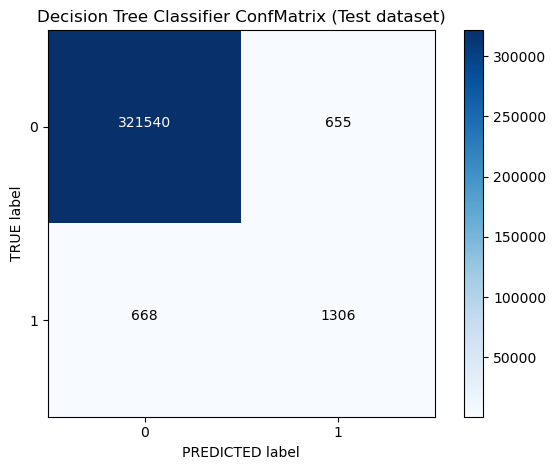

In [16]:
## DECISION TREE CLASSIFIER CONFUSION MATRIX
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, "Decision Tree Classifier ConfMatrix (Test dataset)", classes=[CONST_VALID, CONST_FRAUD])

In [17]:
## DECISION TREE PERFORMANCE: RECALL
recall = recall_score(y_test, y_pred)
print(f"Recall (Decision Tree): {recall}")

Recall (Decision Tree): 0.6616008105369807


In [18]:
## DATA IMBALANCE
data_valid = data_raw[data_raw['is_fraud']==CONST_VALID]
print("Total number of valid transactions: ", data_valid.shape)
data_fraud = data_raw[data_raw['is_fraud']==CONST_FRAUD]
print("Total number of fraud transactions: ", data_fraud.shape)

Total number of valid transactions:  (1289169, 19)
Total number of fraud transactions:  (7506, 19)


In [19]:
# UNDERSAMPLING
data_valid_us = data_valid.sample(n=data_fraud.shape[0])
data_undersample = pd.concat([data_valid_us, data_fraud], ignore_index=True)
data_undersample.is_fraud.value_counts()

is_fraud
0    7506
1    7506
Name: count, dtype: int64

In [20]:
# UNDERSAMPLING MODEL INPUT
X_us = data_undersample.drop(columns=['is_fraud'])
y_us = data_undersample['is_fraud']

In [21]:
# UNDERSAMPLING SPLITING
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=CONST_TEST_SIZE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11259, 18) (3753, 18) (11259,) (3753,)


In [22]:
# UNDERSAMPLED DATASET RANDOM FOREST
random_forest.fit(X_train, y_train.values.ravel())
y_pred = random_forest.predict(X_test)
print("Random Forest Classifier score (Test dataset): ", random_forest.score(X_test, y_test))

Random Forest Classifier score (Test dataset):  0.9541699973354649


In [23]:
# UNDERSAMPLED DATASET DECISION TREE
decision_tree.fit(X_train, y_train.values.ravel())
y_pred = decision_tree.predict(X_test)
print("Decision Tree Classifier score (Test dataset): ", decision_tree.score(X_test, y_test))

Decision Tree Classifier score (Test dataset):  0.9461763922195577


In [24]:
# OVERSAMPLING
X_os, y_os = SMOTE().fit_resample(X, y)
pd.Series.value_counts(y_os)

is_fraud
0    1289169
1    1289169
Name: count, dtype: int64

In [25]:
# OVERSAMPLING SPLITING
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=CONST_TEST_SIZE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1933753, 18) (644585, 18) (1933753,) (644585,)


In [26]:
# OVERSAMPLED DATASET RANDOM FOREST
random_forest.fit(X_train, y_train.values.ravel())
y_pred = random_forest.predict(X_test)
print("Random Forest Classifier score (Test dataset): ", random_forest.score(X_test, y_test))

Random Forest Classifier score (Test dataset):  0.9972044028328304


Confusion matrix, without normalization
[[320742   1586]
 [   216 322041]]


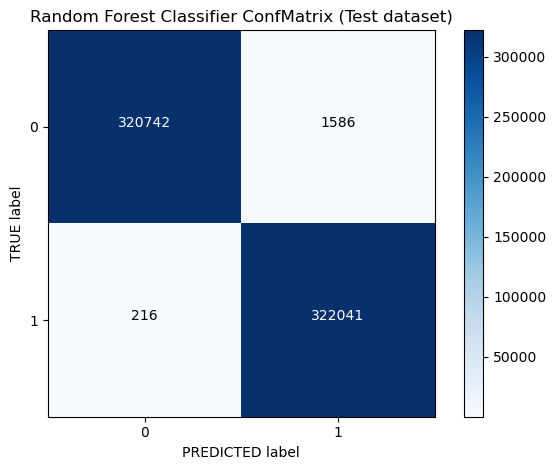

In [27]:
## RANDOM FOREST CLASSIFIER CONFUSION MATRIX
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, "Random Forest Classifier ConfMatrix (Test dataset)", classes=[CONST_VALID, CONST_FRAUD])

In [28]:
# OVERSAMPLED DATASET DECISION TREE
decision_tree.fit(X_train, y_train.values.ravel())
y_pred = decision_tree.predict(X_test)
print("Decision Tree Classifier score (Test dataset): ", decision_tree.score(X_test, y_test))

Decision Tree Classifier score (Test dataset):  0.9842053414212245


Confusion matrix, without normalization
[[315137   7191]
 [  2990 319267]]


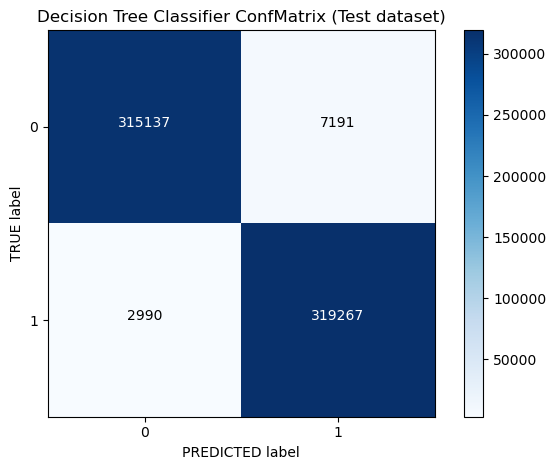

In [29]:
## DECISION TREE CLASSIFIER CONFUSION MATRIX
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, "Decision Tree Classifier ConfMatrix (Test dataset)", classes=[CONST_VALID, CONST_FRAUD])

### Conclusion
- Random Forest classifier has outperformed Decision Tree classifier by satisfying all mentioned conditions
- Though time consuming `Random Forest` model performed as expected with oversampling
- This being a starkly skewed dataset utilizing SMOTE to oversampling yields better results